In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

In [2]:
# Global Variables
stock_name = 'amd' # ticker symbol
model_name = 'Random Forest Classifier' # for display later
days_ahead = 1 # for predicting 1 day ahead
cv = 5 # number of cross validation folds

In [3]:
# Extract, Transform, Load, and Train Test Split
# aapl start date: 12/12/1980, trained 12/23/20
# tsla start date: 06/29/2010, trained 12/23/20
# vbiv start date: 09/04/2002, trained 12/23/20
# vgt start date: 01/26/2004, trained 12/23/20
# idex start date: 05/23/2007, trained 12/23/20
# iyw start date: 05/15/2000, trained 12/23/20
# 
start_dates = {'aapl':'12/12/1980'
               , 'amd': '03/17/1980'
               , 'baba': '09/15/2014'
               , 'crm': '06/23/2004'
               , 'goog': '08/16/2004'
               , 'idex': '05/23/2007'
               , 'iyw': '05/15/2000'
               , 'nvda': '01/22/1999'
               , 'pypl': '07/05/2015'
               , 'tsla': '06/29/2010'
               , 'vbiv': '09/04/2002'
               , 'vgt': '01/26/2004'
              }
X_train, X_test, y_train, y_test, stock_df = a.data(stock_name, start_dates[stock_name], days_ahead)

In [4]:
stock_df.tail(10)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction
Date,,,,,,,,,,,,
2020-12-11,92.330002,90.160004,91.540001,91.650002,28368100.0,91.650002,-0.001202,0.024068,-0.000109,0.019662,-0.004980,1
2020-12-14,95.410004,91.849998,92.209999,94.779999,48026400.0,94.779999,-0.027871,0.038759,0.034152,0.026555,0.001787,-1
2020-12-15,97.980003,95.449997,95.930000,97.120003,57305100.0,97.120003,-0.012405,0.026506,0.024689,0.026816,0.009170,-1
2020-12-16,97.269997,95.459999,97.040001,96.849998,34909000.0,96.849998,0.001958,0.018961,-0.002780,0.016075,0.015265,1
2020-12-17,97.919998,96.250000,97.550003,96.839996,32023700.0,96.839996,0.007278,0.017351,-0.000103,0.017028,0.011170,-1
2020-12-18,97.680000,93.559998,97.269997,95.919998,51823100.0,95.919998,0.013879,0.044036,-0.009500,0.018988,0.009291,-1
2020-12-21,95.279999,91.080002,94.250000,93.230003,47093900.0,93.230003,0.010822,0.046113,-0.028044,0.019003,-0.003148,1
2020-12-22,93.550003,90.529999,93.360001,93.160004,35673700.0,93.160004,0.002142,0.033359,-0.000751,0.011682,-0.008236,-1
2020-12-23,93.129997,91.459999,93.080002,91.550003,25993300.0,91.550003,0.016437,0.018259,-0.017282,0.011789,-0.011136,1


In [5]:
# GridSerach to find best hyperparameters to prevent overfitting, can be commented out once trained
a.rfc_GridSearch(X_train, y_train, stock_name, days_ahead, cv)

/home/david/.local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan ... 0.68517159 0.68517159 0.68517159]
  warnings.warn(


In [6]:
# Load RandomForextClassifier Model
rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

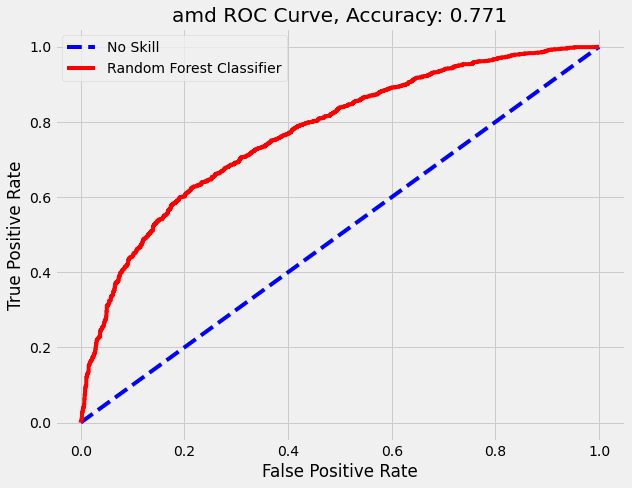

In [7]:
# ROC Curve
a.roc_plot(y_test, y_probs, stock_name, model_name)

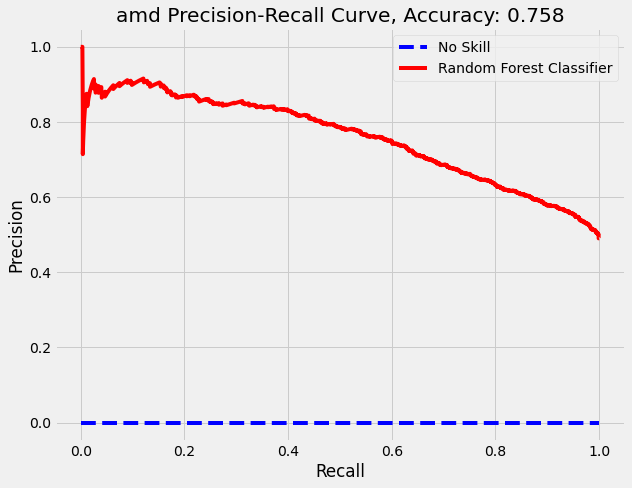

In [8]:
# Precision Recall Curve
a.prec_recall(y_test, y_probs, stock_name, model_name)

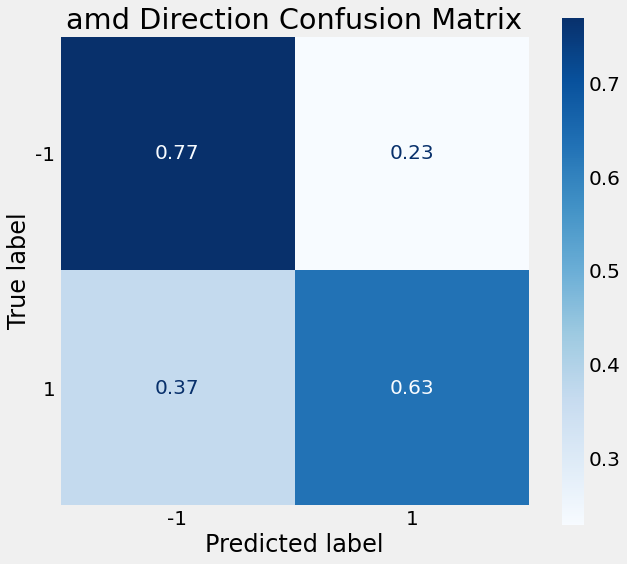

In [9]:
# Confusion Matrix
a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
a.cross_validation(rfc_model
                   , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
                   , stock_df['direction']
                   , cv = 5
                  )

'5 Fold Cross-Validation Score for First RF Model: 0.6912164503394018'

In [11]:
# Prediction, use last day of data
stock_df.iloc[-1]

High          9.251000e+01
Low           9.131000e+01
Open          9.180000e+01
Close         9.181000e+01
Volume        1.670590e+07
Adj Close     9.181000e+01
oc           -1.088726e-04
hl            1.314209e-02
adj           2.839918e-03
5stdev_adj    1.252779e-02
5sma_adj     -1.054747e-02
direction    -1.000000e+00
Name: 2020-12-24 00:00:00, dtype: float64

In [12]:
import numpy as np
last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-1]
last

oc           -0.000109
hl            0.013142
5stdev_adj    0.012528
5sma_adj     -0.010547
Name: 2020-12-24 00:00:00, dtype: float64

### Prediction...

In [13]:
if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
    print(f'Buy {stock_name}')
else:
    print(f'Sell or hold {stock_name}')

Buy amd


In [14]:
# returns on strategy column
stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [15]:
stock_df.tail(5)

,High,Low,Open,Close,Volume,Adj Close,oc,hl,adj,5stdev_adj,5sma_adj,direction,prediction,returns
Date,,,,,,,,,,,,,,
2020-12-18,97.680000,93.559998,97.269997,95.919998,51823100.0,95.919998,0.013879,0.044036,-0.009500,0.018988,0.009291,-1,1,-0.028044
2020-12-21,95.279999,91.080002,94.250000,93.230003,47093900.0,93.230003,0.010822,0.046113,-0.028044,0.019003,-0.003148,1,1,-0.000751
2020-12-22,93.550003,90.529999,93.360001,93.160004,35673700.0,93.160004,0.002142,0.033359,-0.000751,0.011682,-0.008236,-1,1,-0.017282
2020-12-23,93.129997,91.459999,93.080002,91.550003,25993300.0,91.550003,0.016437,0.018259,-0.017282,0.011789,-0.011136,1,1,0.002840
2020-12-24,92.510002,91.309998,91.800003,91.809998,16705900.0,91.809998,-0.000109,0.013142,0.002840,0.012528,-0.010547,-1,1,0.000000


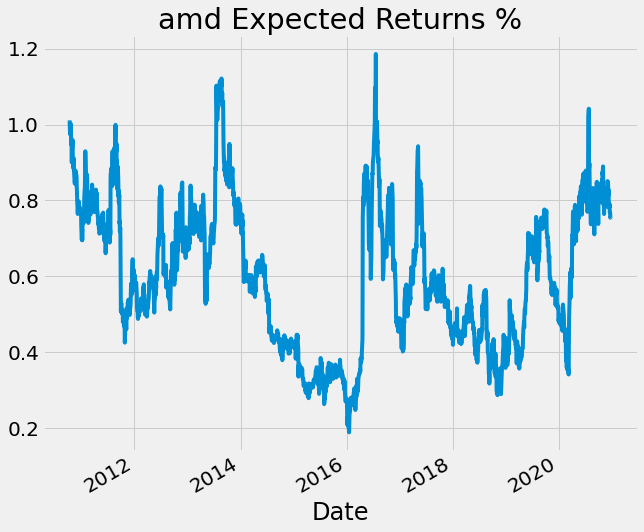

In [16]:
# Don't trade every day!
import matplotlib.pyplot as plt
test_length = len(y_test)
(stock_df['returns'][-test_length:] + 1).cumprod().plot()
plt.title(f'{stock_name} Expected Returns %');

In [17]:
# Model returns if bought on predictions of 1
returns_on_ones = []
for idx in range(-test_length, 0):
    if stock_df['prediction'][idx] == 1:
        returns_on_ones.append(1 + stock_df['returns'][idx])

returns = 1
for x in returns_on_ones:
    returns *= x
returns

7.55421589173756

In [18]:
# multiple times original investment, not bad but...

In [19]:
# If purchased in 2012 and left it until now
test_idx = int(len(stock_df)*0.75)
(stock_df['Close'][-1] - stock_df['Close'][-test_idx]) /stock_df['Close'][-test_idx]

15.505168100421349

In [20]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/